✅ Parsed 8 input vectors (latest batch only).
✅ Parsed 8 outputs (latest batch only).

=== Function 1 (2D) ===
Data size: 22, Output range: [-0.0036, 64.0000]


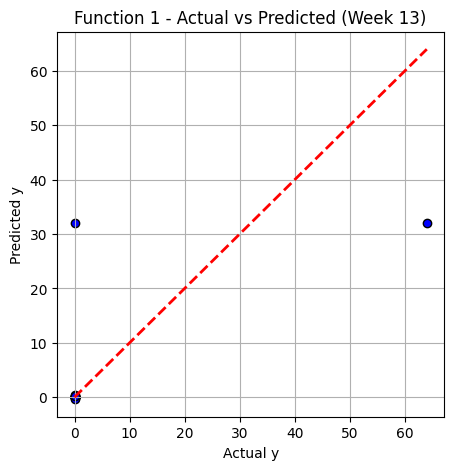

Best predicted output: 0.9252 | RL bonus: 0.0630
Final query to submit: 0.124209-0.507595

=== Function 2 (2D) ===
Data size: 22, Output range: [-0.0656, 3.1124]


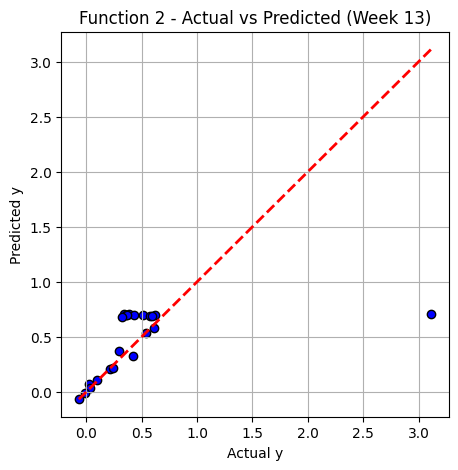

Best predicted output: 0.6904 | RL bonus: 0.0430
Final query to submit: 0.719029-0.753077

=== Function 3 (3D) ===
Data size: 27, Output range: [-0.3989, 71.0000]


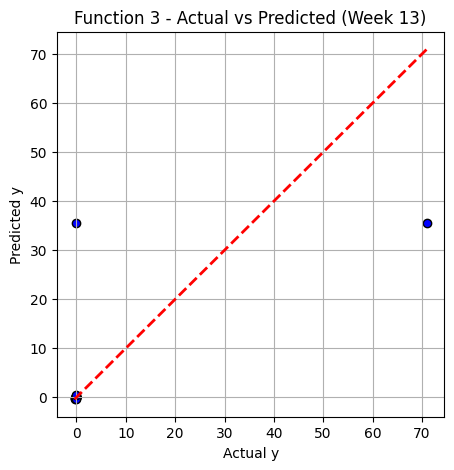

Best predicted output: 25.3756 | RL bonus: -0.4436
Final query to submit: 0.222896-0.630316-0.757769

=== Function 4 (4D) ===
Data size: 42, Output range: [-32.6257, 64.0000]


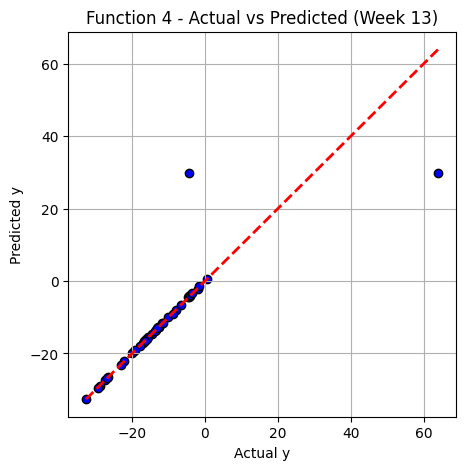

Best predicted output: -0.2655 | RL bonus: 0.5123
Final query to submit: 0.270072-0.289393-0.243931-0.299677

=== Function 5 (4D) ===
Data size: 32, Output range: [0.1129, 4440.5227]


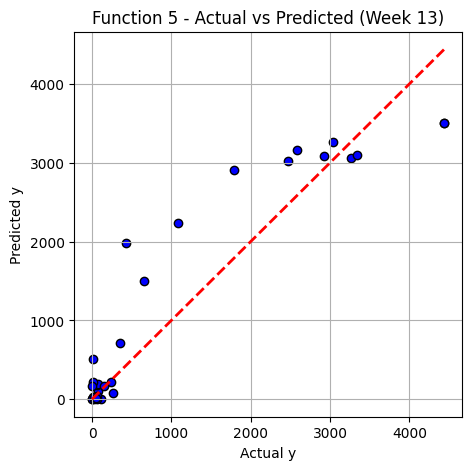

Best predicted output: 3015.2608 | RL bonus: 80.7191
Final query to submit: 0.033359-0.971939-0.818873-0.998298

=== Function 6 (5D) ===
Data size: 32, Output range: [-2.5712, 64.0000]


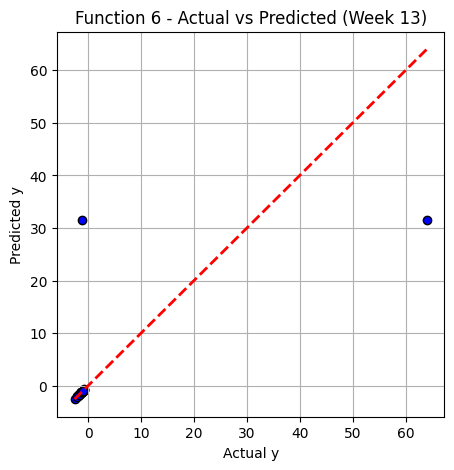

Best predicted output: 13.0315 | RL bonus: 0.5081
Final query to submit: 0.415997-0.101464-0.000924-0.786461-0.484994

=== Function 7 (6D) ===
Data size: 42, Output range: [-0.0787, 2.2926]


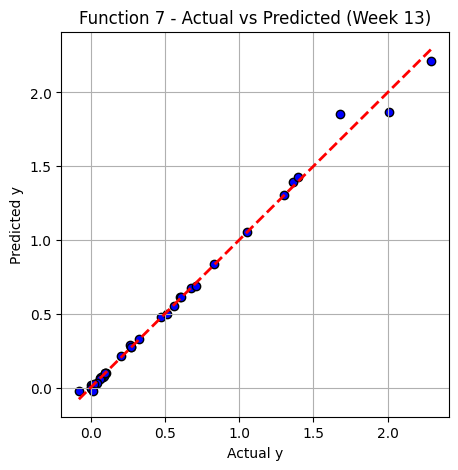

Best predicted output: 1.8044 | RL bonus: 0.0397
Final query to submit: 0.149634-0.310376-0.307590-0.235356-0.380198-0.790189

=== Function 8 (8D) ===
Data size: 52, Output range: [5.5922, 64.0000]


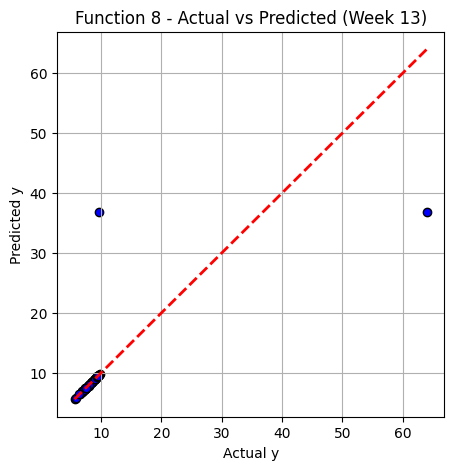

Best predicted output: 22.5755 | RL bonus: 0.2928
Final query to submit: 0.053145-0.266772-0.410405-0.313946-0.612494-0.850047-0.852005-0.828546

💾 Saved all week13 queries to week13_queries.txt


In [1]:
import numpy as np
import os
import re
import ast
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# =========================
# CONFIGURATION
# =========================
base_path = "data/"
inputs_txt = "week12/inputs.txt"      # latest from email (previous round)
outputs_txt = "week12/outputs.txt"
n_candidates = 5000                   # larger candidate pool for final search
epsilon = 0.2                         # exploration rate (RL concept)

# =========================
# LOAD INPUTS (ambil batch terakhir)
# =========================
def load_inputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = "[" + batches[-1].strip().lstrip("[").rstrip("]") + "]"
    last_batch = re.sub(r'array\(', '', last_batch).replace(')', '')
    chunks = re.findall(r'\[([^\[\]]+)\]', last_batch)
    vectors = []
    for ch in chunks:
        nums = [float(x) for x in ch.split(",") if x.strip()]
        vectors.append(np.array(nums))
    print(f"✅ Parsed {len(vectors)} input vectors (latest batch only).")
    return vectors

# =========================
# LOAD OUTPUTS (ambil batch terakhir)
# =========================
def load_outputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = batches[-1].strip()
    last_batch = last_batch.replace("np.float64(", "").replace(")", "")
    last_batch = last_batch.replace("[", "").replace("]", "")
    last_batch = re.sub(r"[^\deE\-\.\,\s]", "", last_batch)
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", last_batch)
    outputs = np.array([float(x) for x in numbers], dtype=float)
    print(f"✅ Parsed {len(outputs)} outputs (latest batch only).")
    return outputs

# =========================
# LOAD NEW DATA
# =========================
new_inputs = load_inputs(inputs_txt)
new_outputs = load_outputs(outputs_txt)

# =========================
# RL-INSPIRED QUERY GENERATION
# =========================
queries_out = []
for i in range(1, 9):
    folder = os.path.join(base_path, f"function_{i}")
    input_file = os.path.join(folder, "week12_inputs.npy")
    output_file = os.path.join(folder, "week12_outputs.npy")

    # Gabungkan data lama + batch baru
    X_prev = np.load(input_file)
    y_prev = np.load(output_file)
    X_combined = np.vstack([X_prev, new_inputs[i-1].reshape(1, -1)])
    y_combined = np.append(y_prev, new_outputs[i-1])

    np.save(os.path.join(folder, "week13_inputs.npy"), X_combined)
    np.save(os.path.join(folder, "week13_outputs.npy"), y_combined)

    dim = X_combined.shape[1]
    print(f"\n=== Function {i} ({dim}D) ===")
    print(f"Data size: {len(X_combined)}, Output range: [{y_combined.min():.4f}, {y_combined.max():.4f}]")

    # Surrogate model (same architecture for consistency)
    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            learning_rate_init=0.001,
            max_iter=3000,
            random_state=42
        )
    )
    model.fit(X_combined, y_combined)

    # Evaluate training fit
    y_pred_train = model.predict(X_combined)
    plt.figure(figsize=(5, 5))
    plt.scatter(y_combined, y_pred_train, c='blue', edgecolor='k')
    plt.plot([y_combined.min(), y_combined.max()],
             [y_combined.min(), y_combined.max()],
             'r--', lw=2)
    plt.title(f'Function {i} - Actual vs Predicted (Week 13)')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.grid(True)
    plt.show()

    # Generate candidates
    candidates = np.random.uniform(0, 1, (n_candidates, dim))
    preds = model.predict(candidates)

    # RL-style exploration bonus based on model confidence (variance)
    mean_pred = np.mean(preds)
    std_pred = np.std(preds)
    exploration_bonus = np.random.uniform(-std_pred, std_pred, size=len(preds)) * epsilon
    combined_score = preds + exploration_bonus  # reward + exploration noise

    best_idx = np.argmax(combined_score)
    best_query = np.clip(candidates[best_idx], 0.0, 1.0)
    query_str = "-".join([f"{x:.6f}" for x in best_query])

    print(f"Best predicted output: {preds[best_idx]:.4f} | RL bonus: {exploration_bonus[best_idx]:.4f}")
    print(f"Final query to submit: {query_str}")
    queries_out.append(f"Function {i}: {query_str}")

# =========================
# SAVE WEEK13 QUERIES
# =========================
with open("week13_queries.txt", "w") as f:
    f.write("\n".join(queries_out))
print("\n💾 Saved all week13 queries to week13_queries.txt")